In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np # to use numpy arrays instead of lists
import pandas as pd # DataFrame (table)
import matplotlib.pyplot as plt # to plot
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.layers import Conv1D, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
!pip install keras-tuner # Install keras-tuner
import keras_tuner as kt # Now import keras_tuner

In [3]:
from sklearn.metrics import classification_report
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [4]:
def leeDatos():

    dataSet = pd.read_csv("gdrive/MyDrive/Colab Notebooks/archive1.zip", header=0, compression='zip')

    return dataSet

In [5]:
def encodeData(dataSet=0):
    dataSet.dropna(inplace=True)

    # Remove any 'neutral' ratings
    dataSet['sentiment'] = ["negative" if x == "neutral" else x for x in dataSet['sentiment']]
    dataSet['sent_analysis'] = np.where(dataSet['sentiment'] == "positive", 1, 0)
    datos = ['text', 'sent_analysis']
    misDatos = dataSet[datos]

    return misDatos

In [6]:
datos = leeDatos()
print(datos)
print("\n")

encodeDatos = encodeData(datos)
print(encodeDatos)
print("\n")
print(encodeDatos['sent_analysis'].mean())
print("\n")

     Year  Month  Day Time of Tweet  \
0    2018      8   18       morning   
1    2018      8   18          noon   
2    2017      8   18         night   
3    2022      6    8       morning   
4    2022      6    8          noon   
..    ...    ...  ...           ...   
494  2015     10   18         night   
495  2021      2   25       morning   
496  2022      5   30          noon   
497  2018      8   10         night   
498  2019      3   25       morning   

                                                  text sentiment     Platform  
0                What a great day!!! Looks like dream.  positive    Twitter    
1       I feel sorry, I miss you here in the sea beach  positive    Facebook   
2                                       Don't angry me  negative     Facebook  
3    We attend in the class just for listening teac...  negative    Facebook   
4                    Those who want to go, let them go  negative   Instagram   
..                                                 

In [7]:
ts_size = .25
trainSet, testSet = train_test_split(encodeDatos, test_size=ts_size, random_state=0)
print(trainSet)
print('trainSet shape: ', trainSet.shape)
print(testSet)
print('testSet shape: ', testSet.shape)
print("\n")

                                                  text  sent_analysis
239                       I love this youtube tutorial              1
59       im thinking that im going to have fun tonight              1
405   the 'no pants' idea could be the new attempt ...              0
390   sorry  friends - I`m swamped with deadlines r...              0
410                            I need blood O negative              0
..                                                 ...            ...
323   u think u have bills Ha!Ii just finished payi...              0
192   it makes me happy to hear a girl talk, or twe...              1
117                    just got up and updated my ipod              0
47         im soo bored, I don't like this music video              0
172                                     hope he is ok!              1

[374 rows x 2 columns]
trainSet shape:  (374, 2)
                                                  text  sent_analysis
90                    Follow me, I will 

In [8]:
vocab_size = 15000
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

training_sentences= trainSet['text']
training_labels = trainSet['sent_analysis']
testing_sentences = testSet['text']
testing_labels = testSet['sent_analysis']

In [9]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [11]:
def model_builder(hp):
    vocab_size = 15000
    hp_embedding_dim = hp.Int('embedding_dim', min_value=4, max_value=48 , step=4)
    hp_max_length = hp.Int('input_length', min_value=60, max_value=140, step=5)
    hp_filters = hp.Int('filters', min_value=2, max_value=12, step=2)
    hp_kernel_size = hp.Int('kernel_size', min_value=2, max_value=6, step=1)
    hp_pool_size = hp.Int('pool_size', min_value=2, max_value=6, step=1)
    hp_activation_conv = hp.Choice('activation_conv', values=['linear', 'softplus', 'relu', 'sigmoid', 'tanh'])
    hp_activation_dense = hp.Choice('activation_dense', values=['linear', 'softplus', 'relu', 'sigmoid', 'tanh'])
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

    model = Sequential([
                      Embedding(vocab_size, hp_embedding_dim, input_length=hp_max_length),
                      Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation=hp_activation_conv),
                      AveragePooling1D(pool_size=hp_pool_size),
                      Flatten(),
                      Dense(2, activation=hp_activation_dense),
                      Dense(1, activation='sigmoid', name="Outpul_layer")
                      ])

    opt = hp_optimizer
    loss_fun = 'binary_crossentropy'
    acc = ['accuracy']

    model.compile(
        optimizer = opt,
        loss = loss_fun,
        metrics = acc
        )

    return model

In [12]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=18,
                     factor=3,
                     )

Reloading Tuner from ./untitled_project/tuner0.json


In [13]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [14]:
validation_split_size = 0.35
num_epochs = 45

tuner.search(training_padded,
             training_labels,
             validation_split=validation_split_size,
             epochs=num_epochs,
             callbacks=[stop_early],
             verbose=2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete.
The best 'input_length' for the embedding layer is {best_hps.get('input_length')}
""")

The hyperparameter search is complete.
The best 'input_length' for the embedding layer is 130



In [15]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(training_padded,
                    training_labels,
                    validation_split=validation_split_size,
                    epochs=num_epochs,
                    verbose=2)

Epoch 1/45
8/8 - 5s - 595ms/step - accuracy: 0.5391 - loss: 0.6897 - val_accuracy: 0.6718 - val_loss: 0.6742
Epoch 2/45
8/8 - 0s - 17ms/step - accuracy: 0.6749 - loss: 0.6621 - val_accuracy: 0.6718 - val_loss: 0.6505
Epoch 3/45
8/8 - 0s - 50ms/step - accuracy: 0.6749 - loss: 0.6335 - val_accuracy: 0.6718 - val_loss: 0.6331
Epoch 4/45
8/8 - 0s - 31ms/step - accuracy: 0.6749 - loss: 0.6198 - val_accuracy: 0.6718 - val_loss: 0.6317
Epoch 5/45
8/8 - 0s - 28ms/step - accuracy: 0.6749 - loss: 0.6170 - val_accuracy: 0.6718 - val_loss: 0.6313
Epoch 6/45
8/8 - 0s - 40ms/step - accuracy: 0.6749 - loss: 0.6106 - val_accuracy: 0.6718 - val_loss: 0.6286
Epoch 7/45
8/8 - 0s - 40ms/step - accuracy: 0.6749 - loss: 0.6040 - val_accuracy: 0.6718 - val_loss: 0.6273
Epoch 8/45
8/8 - 0s - 37ms/step - accuracy: 0.6749 - loss: 0.5985 - val_accuracy: 0.6718 - val_loss: 0.6261
Epoch 9/45
8/8 - 0s - 35ms/step - accuracy: 0.6749 - loss: 0.5912 - val_accuracy: 0.6718 - val_loss: 0.6249
Epoch 10/45
8/8 - 0s - 40ms

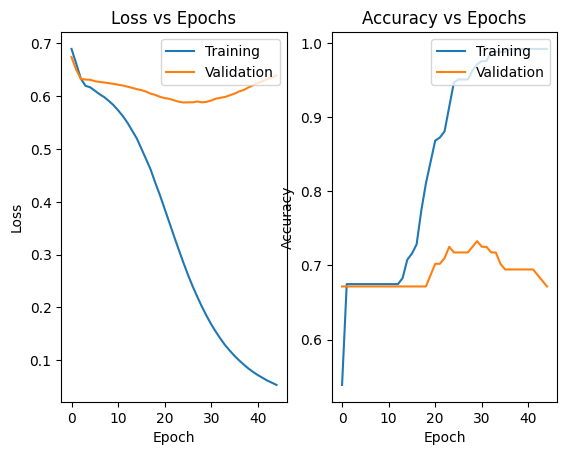

In [16]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
fig.add_subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [17]:
print(model.evaluate(training_padded, training_labels, verbose=2))
print("\n")

#### predict train data ######
df_train = pd.DataFrame()
df_train['real'] = training_labels
df_train['pred'] = model.predict(training_padded).reshape(1,len(training_padded))[0]
print(round(df_train))
print(model.evaluate(testing_padded,testing_labels, verbose=2))
print("\n")

# test data
df_test = pd.DataFrame()
df_test['real'] = testing_labels
df_test['pred'] = model.predict(testing_padded).reshape(1,len(testing_padded))[0]
print(round(df_test))

report = classification_report(testing_labels, round(df_test['pred']), output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)
print("\n")

12/12 - 0s - 12ms/step - accuracy: 0.8797 - loss: 0.2571
[0.25706878304481506, 0.8796791434288025]


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
     real  pred
0       1   1.0
1       1   1.0
2       0   0.0
3       0   0.0
4       0   0.0
..    ...   ...
369     0   0.0
370     1   1.0
371     0   0.0
372     0   1.0
373     1   1.0

[374 rows x 2 columns]
4/4 - 0s - 17ms/step - accuracy: 0.7440 - loss: 0.5506
[0.5506469011306763, 0.7440000176429749]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
     real  pred
0       0   0.0
1       0   0.0
2       1   1.0
3       1   0.0
4       1   0.0
..    ...   ...
120     0   0.0
121     0   1.0
122     1   1.0
123     0   0.0
124     0   0.0

[125 rows x 2 columns]
              precision    recall  f1-score  support
0              0.728972  0.962963  0.829787   81.000
1              0.833333  0.340909  0.483871   44.000
accuracy       0.744000  0.744000  0.744000    0.744
macro avg      0.781153  0.651936  0.656829  125.000
weighted avg   0.765707  